# Import libraries and modules

In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#from sklearn.impute import KNNImputer

from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Constants

In [2]:
DATA_DIR = '/content/gdrive/MyDrive/DataBases_ANSUR_SPRING-CAESAR'

GENDERS = ['female', 'male']

IMP_MEAS_SOH = ['weight_kg',
                'stature_cm', 
                'chest_girth',
                'waist_girth',
                'hips_buttock_girth',
                'shoulder_girth',
                'thigh_girth',
                'sleeveoutseam_length',
                'crotchheight_length',
                'waistback_length']

# Functions

In [3]:
def process_db_values(train, test):
  # performin min-max scaling each continuous feature column to
  # the range [0, 1]
  cs = MinMaxScaler()
  train = cs.fit_transform(train)
  test = cs.transform(test) 

  # return the concatenated training and testing data
  return (train, test), cs

# Load Data

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Load dataframe
file_encoding = "ISO-8859-1"    # 'utf8'

# ANSUR df
ansurDF_list = list()

for gender in GENDERS:
  db_dir =  os.path.join(DATA_DIR, f'ANSUR_II_{gender}_perfit2022.csv')
  ansurDF_list.append(pd.read_csv(db_dir, encoding = file_encoding, converters={'ID': str}))

# SPRING df
springDF_list = list()

for gender in GENDERS:
  db_dir =  os.path.join(DATA_DIR, f'measurements_perfit2022_{gender}.csv')

  df = pd.read_csv(db_dir, encoding = file_encoding, converters={'ID': str})
  df = df.drop('bodyID', axis=1)
  springDF_list.append(df)

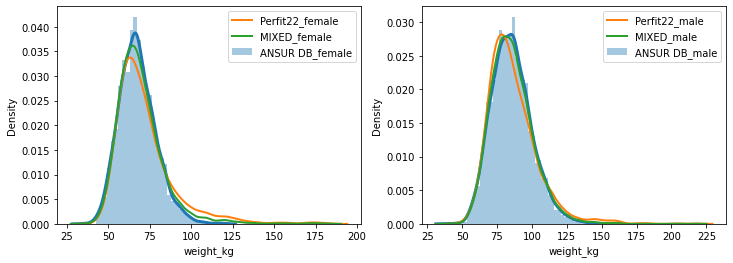

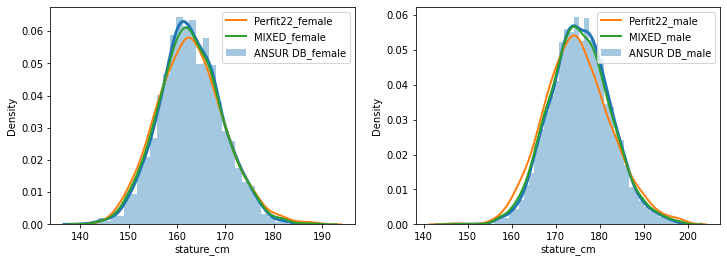

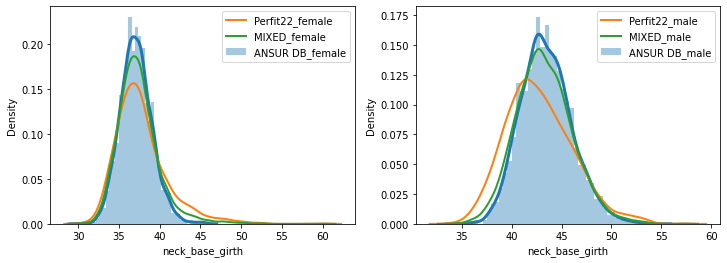

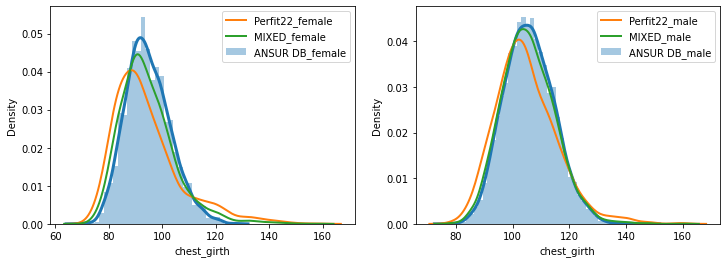

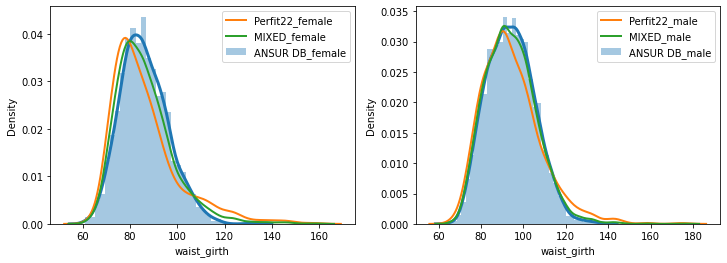

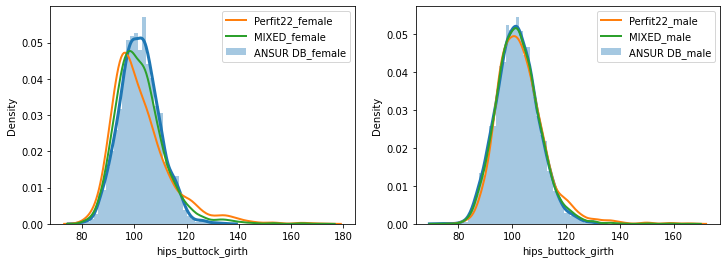

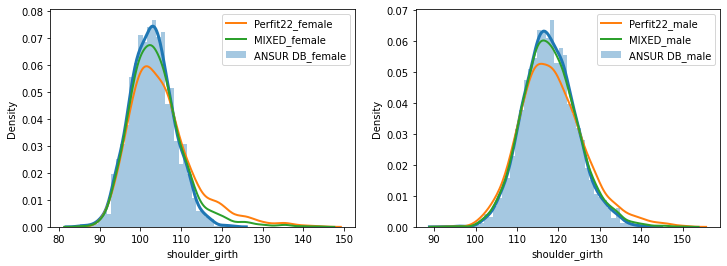

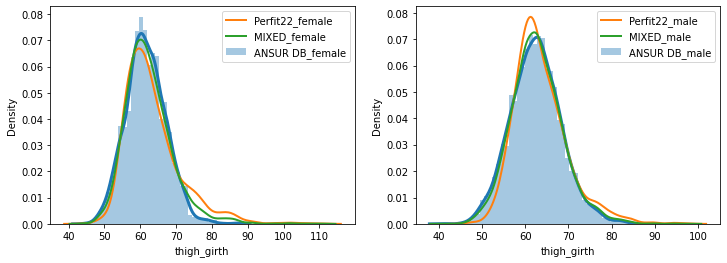

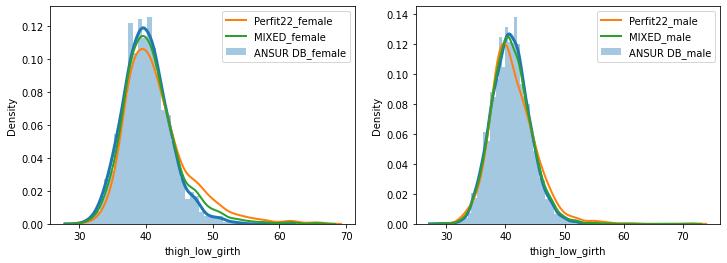

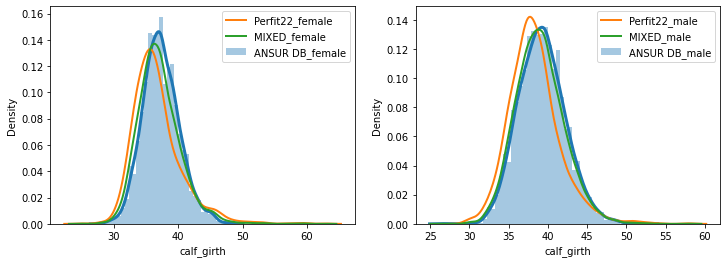

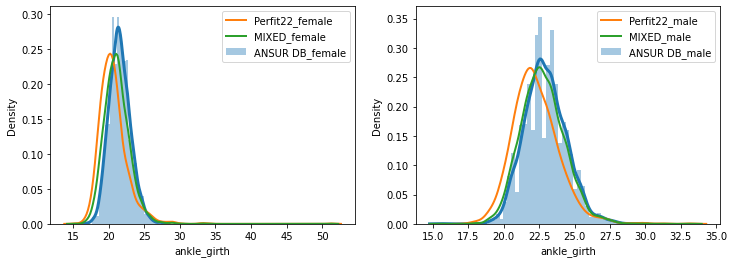

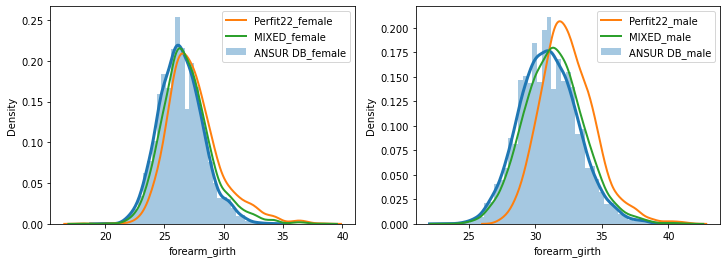

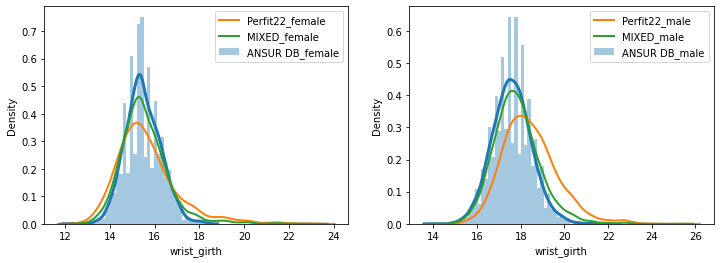

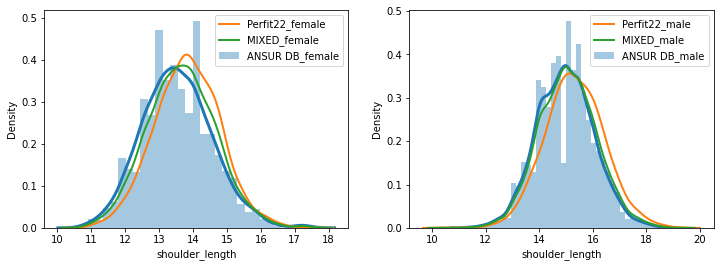

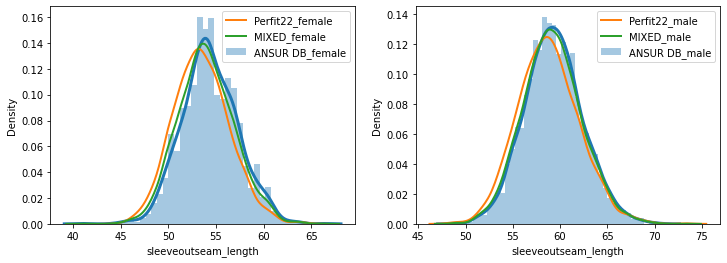

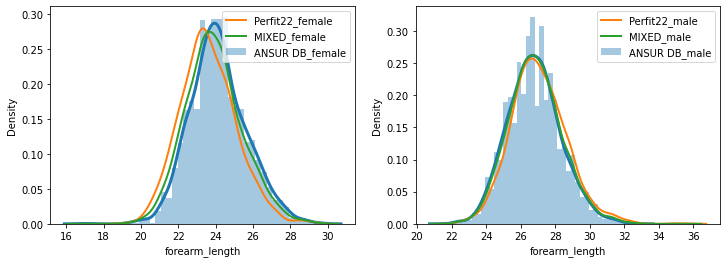

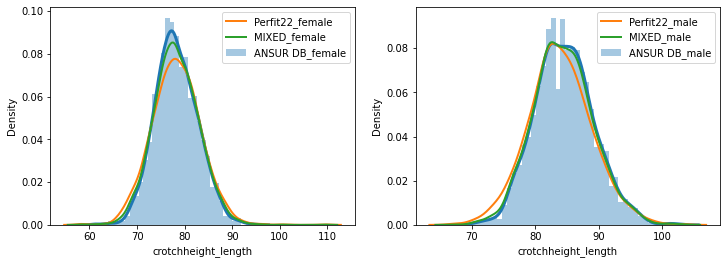

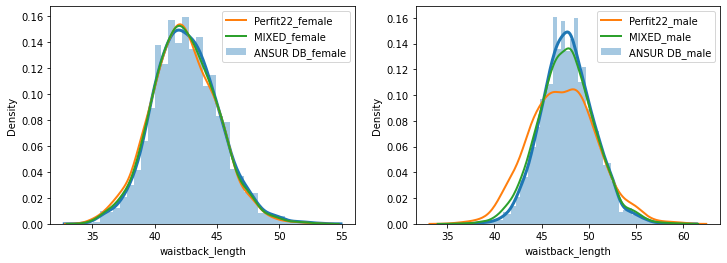

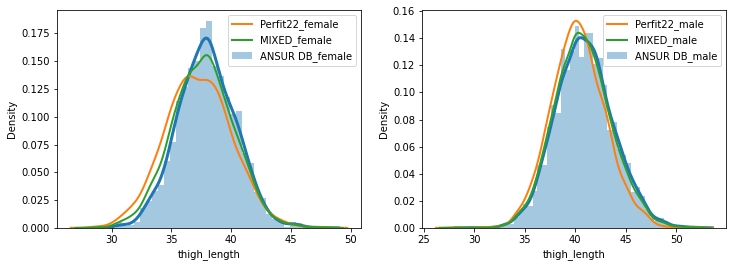

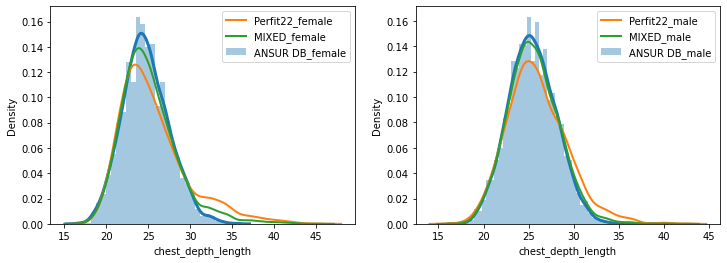

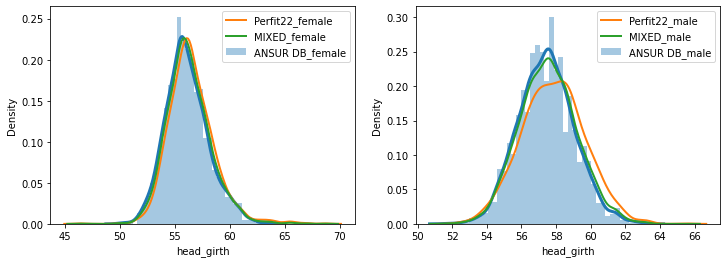

In [7]:
# Compare Databases

# for i, col_name in enumerate(IMP_MEAS_SOH):  
for i, col_name in enumerate(df.columns):  

  plt.figure(figsize=(12,4))

  for g, gender in enumerate(GENDERS):   
    x = ansurDF_list[g][col_name]
    y = springDF_list[g][col_name]
    z = pd.concat([ansurDF_list[g][col_name], springDF_list[g][col_name]], axis=0)

    min_value = x.mean()
    max_value = x.mean()

    bins = np.linspace(min_value, max_value, 40)

    ## Draw the density plot
    plt.subplot(1, 2, g+1)
    sns.distplot(x, hist = True, kde = True, kde_kws = {'linewidth': 3}, label=f'ANSUR DB_{gender}')
    sns.distplot(y, hist = False, kde = True, kde_kws = {'linewidth': 2}, label=f'Perfit22_{gender}')   
    sns.distplot(z, hist = False, kde = True, kde_kws = {'linewidth': 2}, label=f'MIXED_{gender}')           
    plt.legend(loc='upper right')
  plt.show()

In [10]:
#ansurDF_list[1]['weight_kg'].max()
g = 1
print("Gender: ", GENDERS[g])
print('%-22s %-6s %-6s'%('Measurement', 'SPRING', 'ANSUR'))
for col in springDF_list[g].columns:
  print('%-22s %-6.2f %-6.2f'%(col, springDF_list[g][col].max(), ansurDF_list[g][col].max()))
  #print('%22s %6f %6f'%(col, springDF_list[g][col].min(), ansurDF_list[g][col].min()))
#print(springDF_list[1].max())

Gender:  male
Measurement            SPRING ANSUR 
weight_kg              217.17 144.20
stature_cm             198.91 199.30
neck_base_girth        57.18  54.50 
chest_girth            160.65 146.90
waist_girth            176.54 137.90
hips_buttock_girth     165.68 130.50
shoulder_girth         150.23 141.30
thigh_girth            97.55  84.30 
thigh_low_girth        71.27  54.00 
calf_girth             57.92  52.30 
ankle_girth            33.15  29.30 
forearm_girth          41.42  40.20 
wrist_girth            25.33  21.60 
shoulder_length        19.23  18.50 
sleeveoutseam_length   73.23  70.90 
forearm_length         35.62  32.80 
crotchheight_length    103.50 103.10
waistback_length       59.95  59.80 
thigh_length           51.76  52.00 
chest_depth_length     42.34  38.30 
head_girth             65.41  63.30 


# Weight Prediction

In [ ]:
# DF to Npy

ansurDF_NPlist = list()
springDF_NPlist = list()

'''
for g, gender in enumerate(GENDERS):

  aux_df = ansurDF_list[g].copy(deep=True)
  aux_df.drop(aux_df.columns.difference(IMP_MEAS_SOH), 1, inplace=True)
  ansurDF_NPlist.append(aux_df.to_numpy(dtype='float'))

  aux_df = springDF_list[g].copy(deep=True)
  aux_df.drop(aux_df.columns.difference(IMP_MEAS_SOH), 1, inplace=True)
  springDF_NPlist.append(aux_df.to_numpy(dtype='float'))
'''

for g, gender in enumerate(GENDERS):
  ansurDF_NPlist.append(ansurDF_list[g].to_numpy(dtype='float'))
  springDF_NPlist.append(springDF_list[g].to_numpy(dtype='float'))

In [ ]:
#KNeighborsRegressor(n_neighbors=5, weights="uniform"),

IMPUTE_ESTIMATORS = [
    BayesianRidge(n_iter=100, tol=1e-3),
    LinearRegression(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=10, weights="distance",
                        n_jobs=-1),
    RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True,
                          max_samples=0.5, n_jobs=2, random_state=0,)
]

# solver = IterativeImputer(random_state=0, estimator=IMPUTE_ESTIMATORS[-1], max_iter = 20, tol=1e-5, verbose=0)
solver = IterativeImputer(estimator=IMPUTE_ESTIMATORS[0])
scaler = StandardScaler()
# scaler = MinMaxScaler()
for g, gender in enumerate(GENDERS):
  pred_weight = list()
  for i in range(5):   #range(springDF_NPlist[g].shape[0])
    kn_meas = scaler.fit_transform(ansurDF_NPlist[g])

    uk_meas = np.array(springDF_NPlist[g][i, :], copy=True)
    uk_meas[0] = np.nan
    uk_meas = scaler.transform(uk_meas.reshape(1, -1))
    #print(uk_meas)
    measures = np.vstack([kn_meas, uk_meas])

    predicted_data = solver.fit_transform(measures)
    output_data = scaler.inverse_transform(predicted_data[-1:])
    pred_weight.append(round(output_data[0][0], 2))

    print(springDF_list[g].iloc[i, 0], round(output_data[0][0], 2))
  print(pred_weight)

68.82 66.02
60.99 57.55
108.76 105.34
52.37 48.91
68.95 66.23
[66.02, 57.55, 105.34, 48.91, 66.23]
158.89 145.02
104.49 104.05
94.54 97.01
84.52 86.26
92.0 93.65
[145.02, 104.05, 97.01, 86.26, 93.65]


[67.37, 57.07, 103.06, 48.75, 66.85]
[141.02, 104.02, 97.45, 87.44, 90.78]

In [ ]:
pred_weight

[81.5, 72.6, 92.9, 79.4, 94.6]

# Testing Regression Models on ANSUR

In [ ]:
# Join ANSUR and SPRING
mixedDF_list = list()

for g, gender in enumerate(GENDERS):
  # print(pd.concat([ansurDF_list[g][:], springDF_list[g][:]], axis=0).reset_index())
  mixedDF_list.append(pd.concat([ansurDF_list[g][:], springDF_list[g][:]], axis=0).reset_index())

In [ ]:
ansurDF_list[g].describe()

,weight_kg,stature_cm,neck_base_girth,chest_girth,waist_girth,hips_buttock_girth,shoulder_girth,thigh_girth,thigh_low_girth,calf_girth,...,forearm_girth,wrist_girth,shoulder_length,sleeveoutseam_length,forearm_length,crotchheight_length,waistback_length,thigh_length,chest_depth_length,head_girth
count,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,...,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000
mean,85.523959,175.621460,43.459603,105.870554,94.057741,101.951886,117.858746,62.514233,40.928785,39.226066,...,31.005855,17.591671,14.977609,59.312445,26.788266,84.592994,47.761244,40.927266,25.384713,57.437286
std,14.220699,6.855079,2.567400,8.743527,11.170587,7.668107,6.358638,5.845217,3.187332,2.970884,...,2.199099,0.895506,1.051331,3.081963,1.541718,4.649916,2.772829,2.841679,2.624674,1.604852
min,39.300000,149.100000,35.000000,77.400000,64.800000,73.700000,92.500000,41.200000,29.000000,26.600000,...,23.300000,14.100000,11.300000,48.800000,21.600000,70.200000,38.300000,29.800000,17.600000,51.600000
25%,75.600000,171.000000,41.700000,99.600000,85.700000,96.700000,113.500000,58.600000,38.725000,37.200000,...,29.500000,17.000000,14.200000,57.200000,25.700000,81.400000,45.925000,39.000000,23.600000,56.300000
50%,84.600000,175.500000,43.300000,105.600000,93.700000,101.700000,117.600000,62.400000,40.800000,39.200000,...,31.000000,17.600000,15.000000,59.200000,26.700000,84.500000,47.700000,40.800000,25.300000,57.400000
75%,94.400000,180.200000,45.075000,111.700000,101.600000,106.800000,122.000000,66.200000,42.900000,41.200000,...,32.400000,18.200000,15.700000,61.200000,27.800000,87.600000,49.500000,42.700000,27.200000,58.500000
max,144.200000,199.300000,54.500000,146.900000,137.900000,130.500000,141.300000,84.300000,54.000000,52.300000,...,40.200000,21.600000,18.500000,70.900000,32.800000,103.100000,59.800000,52.000000,38.300000,63.300000


In [ ]:
g = 1

(trainData, testData) = train_test_split(mixedDF_list[g], train_size=0.8, shuffle='True')   #, random_state=42

max_value = mixedDF_list[g]['weight_kg'].max()
y_train = trainData['weight_kg'] / max_value
y_test =  testData['weight_kg'] / max_value

trainData2 = trainData.drop('weight_kg', axis=1)
testData2 = testData.drop('weight_kg', axis=1)

(X_train, X_test), dataMeasX_scaler = process_db_values(trainData2, testData2)

In [ ]:
max_value

217.17

In [ ]:
# Testing Regression Models

'''
IMPUTE_ESTIMATORS = [
    BayesianRidge(),
    LinearRegression(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=50, weights="uniform"),
    RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True,
                          max_samples=0.5, n_jobs=2, random_state=0,)
]
'''
# Compare results to Random Forest regression on stats-only from scikit-learn
#RF_model = RandomForestRegressor()   #max_depth=2, random_state=0
#REGRE_model = KNeighborsRegressor(n_neighbors=10, weights="uniform")
REGRE_model = BayesianRidge()
REGRE_model.fit(X_train, y_train)   #train_MeasXuni, train_MeasYuni

preds = REGRE_model.predict(X_test)

In [ ]:
y_test_list = list(y_test)
for i, val in enumerate(y_test_list):
  print(round(val * max_value, 2), round(preds[i] * max_value, 2))


96.3 98.96
113.51 112.91
88.9 86.48
73.0 71.57
65.6 65.08
115.8 113.37
127.8 124.04
90.0 88.96
90.45 93.46
71.6 71.19
105.1 104.28
68.2 69.31
89.16 92.44
102.5 103.1
82.8 83.21
76.1 75.97
105.1 103.15
90.6 89.23
64.4 63.71
88.4 89.26
79.7 77.99
85.81 87.53
95.1 93.25
95.1 93.15
98.7 100.8
73.68 74.39
64.05 64.41
82.0 82.13
73.98 73.93
68.64 67.06
67.4 65.46
71.2 71.14
76.2 77.97
74.4 73.13
97.2 94.82
87.3 88.2
93.8 97.26
97.9 100.05
79.23 80.76
78.7 77.94
92.2 95.38
102.0 104.42
73.5 71.6
74.5 75.18
132.5 126.0
86.7 89.28
77.3 77.65
96.3 98.53
112.29 111.56
80.6 80.02
70.9 69.97
97.05 99.26
86.0 85.19
117.76 117.96
138.96 133.85
89.0 89.11
59.6 55.94
106.2 104.47
70.0 69.9
86.2 86.65
85.9 86.98
85.8 88.29
75.74 75.86
78.0 79.09
55.2 50.9
78.6 78.89
99.71 99.02
88.79 91.72
159.63 145.25
101.1 100.22
103.7 102.47
83.6 82.97
69.68 69.66
99.08 102.39
75.11 75.65
119.3 116.02
78.57 80.84
85.36 86.62
68.7 68.49
66.1 65.76
100.9 102.3
99.0 98.63
69.44 67.82
101.5 101.68
120.4 116.63
97.41 97.